In [77]:
import pandas as pd
import numpy as np
import datetime 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from arch import arch_model
import pmdarima as pm
from sklearn.metrics import mean_squared_error

import seaborn as sns
from sklearn.preprocessing import StandardScaler 
#import prince
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [271]:
df = pd.read_csv('data/USDEUR.csv')
df.set_index('Date',inplace=True)
df=df.dropna()

In [272]:
df['Spread'] = 100 * (df['USD'] - df ['EUR'])
df['Returns'] = df['Spread'].diff(1)
df=df.dropna()

In [273]:
df

,USD,EUR,FX,FXBasis,USDOIS,EUROIS,ESTROIS,Spread,Returns
Date,,,,,,,,,
2018-01-03,2.5838,1.5157,1.2015,-21.000,37.000,7.400,16.1315,106.81,0.81
2018-01-04,2.5848,1.4900,1.2068,-21.625,36.500,7.300,15.8425,109.48,2.67
2018-01-05,2.6109,1.5063,1.2029,-20.125,36.625,7.000,15.6578,110.46,0.98
2018-01-08,2.6100,1.4990,1.1967,-19.875,36.375,7.000,15.5315,111.10,0.64
2018-01-09,2.6930,1.5440,1.1937,-20.375,36.125,7.000,15.9205,114.90,3.80
...,...,...,...,...,...,...,...,...,...
2020-11-12,1.3005,0.0520,1.1806,-7.875,18.880,3.795,12.3700,124.85,-6.13
2020-11-13,1.3146,0.0450,1.1834,-5.875,18.875,3.800,12.2000,126.96,2.11
2020-11-16,1.3395,0.0380,1.1852,-8.375,18.885,3.603,12.1000,130.15,3.19


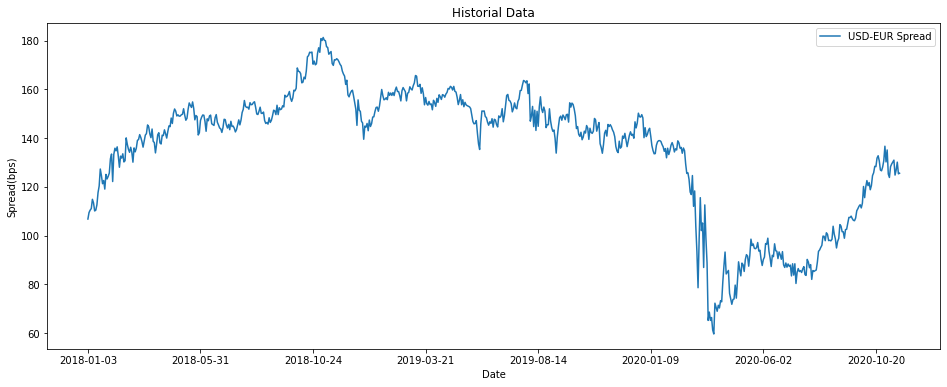

In [274]:
# Plot historical price data
fig, ax = plt.subplots(figsize=(16,6))
df['Spread'].plot(ax=ax,label='USD-EUR Spread')
plt.title('Historial Data')
plt.xlabel('Date')
plt.ylabel('Spread(bps)')
plt.legend()
plt.show()

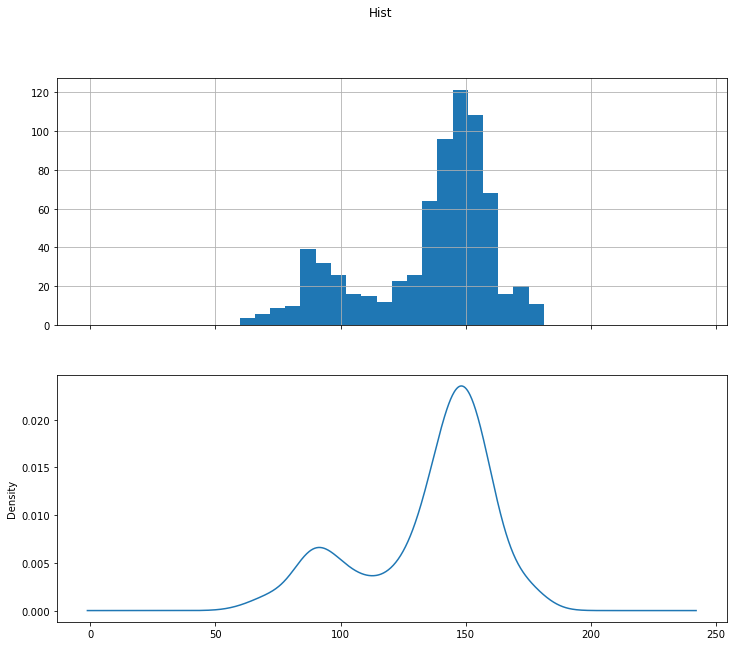

In [275]:
# Histogram/density plots of time series
fig, ax = plt.subplots(2, figsize=(12,10), sharex=True)
fig.suptitle('Hist')
df['Spread'].hist(ax=ax[0], bins=20)
df['Spread'].plot(kind='kde', ax=ax[1])
plt.show()

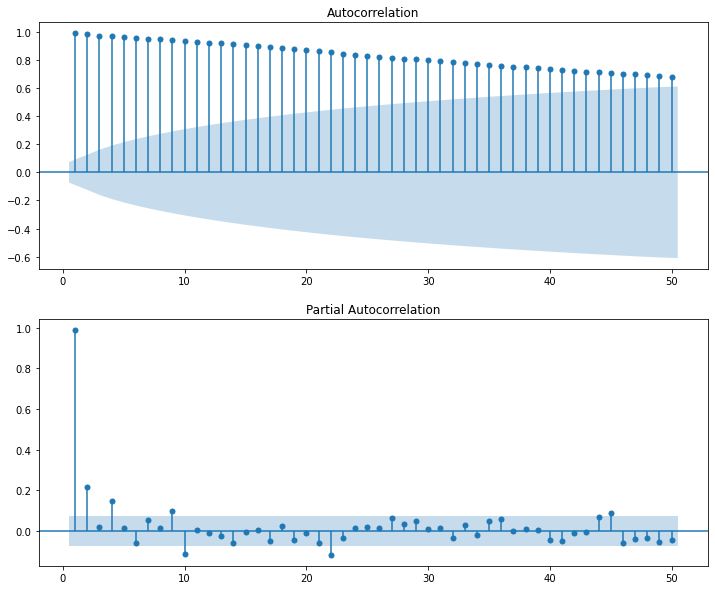

In [276]:
# ACF and PACF plots of time series
def plot_acf_pacf(df):
    # Create figure
    fig, ax = plt.subplots(2, figsize=(12,10))
    # Make ACF plot
    plot_acf(df, lags=50, zero=False, ax=ax[0])
    # Make PACF plot
    plot_pacf(df, lags=50, zero=False, ax=ax[1])
    # Show plots
    return plt.show()

plot_acf_pacf(df['Spread'])

ADF Statistic: -9.236904
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


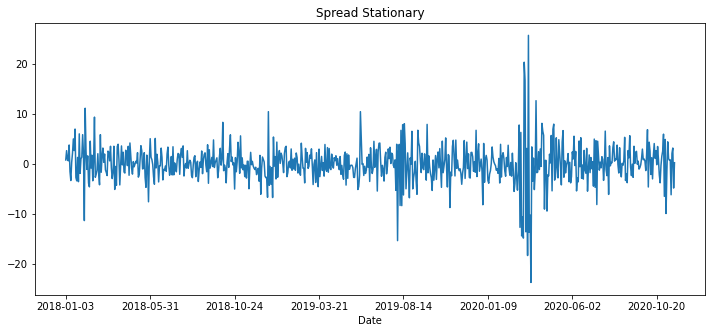

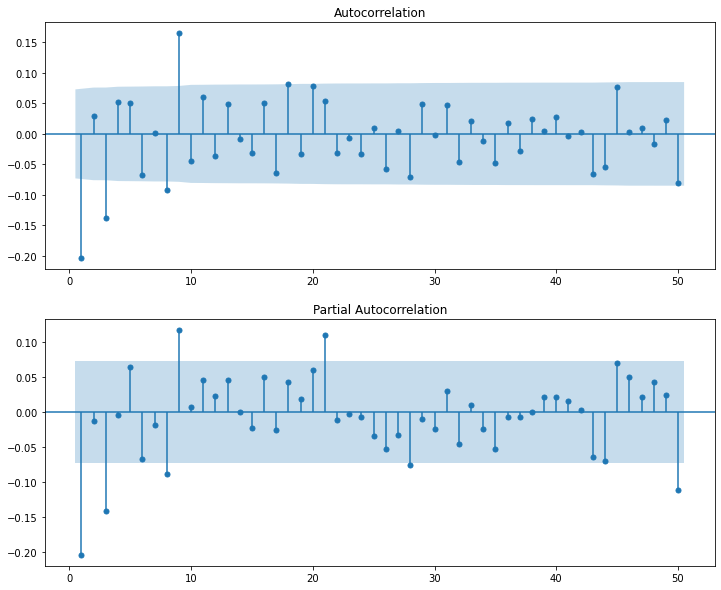

In [277]:
# Transform data from non-stationary to stationary
# Method 1: difference data
stationary = df['Returns']
# # Method 2: take the log
# stationary = np.log(X)
# # Method 3: take the square root 
# stationary = np.sqrt(X)
# # Method 4: take the proprtional change
# stationary = X.pct_change(1)
stationary.dropna(axis=0, inplace=True)

# The augmented Dicky-Fuller test - check if stationary
result = adfuller(stationary)
# test statistic - more negative means more likely to be stationary
print('ADF Statistic: %f' % result[0])
# p-value - reject null hypothesis: non-stationary
print('p-value: %f' % result[1])
# critical test statistics - p-values: test statistic for null hypothesis
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# plot stationary dataset
stationary.plot(figsize=(12,5))
plt.title('Spread Stationary')
plt.show()

# plot ACF & PACF of stationary dataset
plot_acf_pacf(stationary)

In [278]:
# Searching over SARIMA model orders
class Auto_Arima():
    def __init__(self, df, start_p=1, start_q=1, max_p=10, max_q=10,\
        seasonal=False, information_criterion='aic'):
        self.df = df
        self.start_p = start_p
        self.start_q = start_q
        self.max_p = max_p
        self.max_q = max_q
        self.seasonal = seasonal
        self.information_criterion = information_criterion

    def arima_results(self):
        results = pm.auto_arima(
            self.df,
            start_p = self.start_p,
            start_q = self.start_q,
            max_p = self.max_p,
            max_q = self.max_q,
            seasonal = self.seasonal,
            # m = 14,
            # D = 1,
            # start_P = 1,
            # start_Q = 1,
            # max_P = 10,
            # max_Q = 10,
            information_criterion = self.information_criterion,
            trace = False,
            error_action = 'ignore',
            suppress_warnings=True,
            stepwise = True,
            scoring = 'mse'
        )
        return results

Train: 505, Test: 217


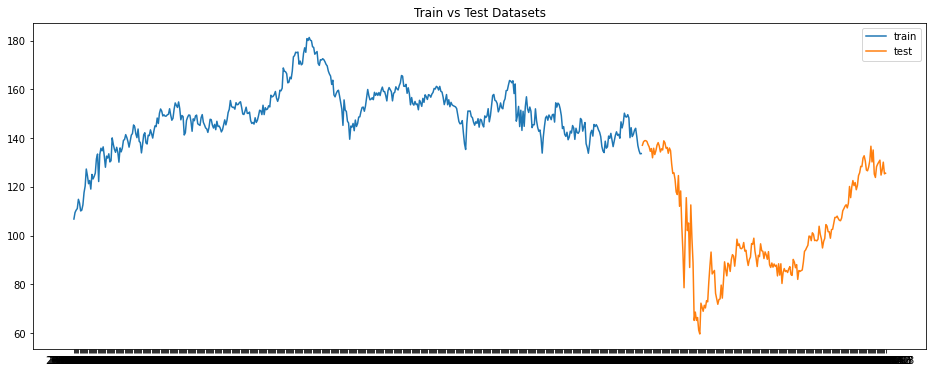

In [280]:
# Train test split
def train_test_split(X, size=0.7):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

train, test = train_test_split(X=df['Spread'], size=0.7)
print(f'Train: {len(train)}, Test: {len(test)}')

# Plot train & test datasets
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(train,label='train')
ax.plot(test,label='test')
ax.legend()
plt.title("Train vs Test Datasets")
plt.show()

In [266]:
# Fit model with auto-arima
arima_model = Auto_Arima(train)
results = arima_model.arima_results()

In [267]:
# Check residuals
# Prob(Q) - p-value for null hypothesis that residuals are uncorrelated
# Prob(JB) - p-value for null hypothesis that residuals are normal
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  505
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1263.425
Date:                Sat, 05 Dec 2020   AIC                           2530.850
Time:                        18:09:04   BIC                           2539.299
Sample:                             0   HQIC                          2534.164
                                - 505                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2182      0.038     -5.816      0.000      -0.292      -0.145
sigma2         8.7205      0.411     21.215      0.000       7.915       9.526
Ljung-Box (Q):                       46.03   Jarque-

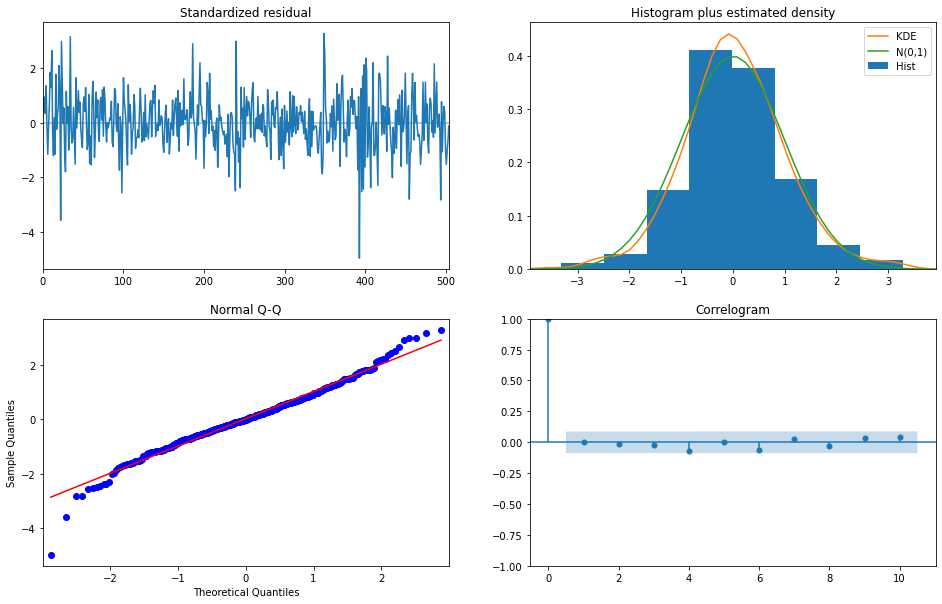

In [268]:
# Residuals are not correlated and are not normally distributed

# Plot diagnostics - check residuals:
# 1.Standardized residual - should be white noise
# 2.Histogram plus estimated density - expected normal distribution
# and kde overlap each other
# 3.Normal Q-Q - all points should lay on red line, except perhaps
# for some values at both ends
# 4.Correlogram - acf plot, 95% should not be significant
plot_diag = results.plot_diagnostics(figsize=(16,10))

In [114]:
def plot_train_test(train, test, df):
    # Plot the predictions for validation set
    plt.figure(figsize=(16,6))
    plt.plot(train, label='train')
    plt.plot(test, label='test')
    plt.plot(df, label='predicted')
    plt.title('Prediction for USD-EUR Spread')
    plt.legend()
    plt.show()

    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, df))
    print(f'RMSE: {rmse:.2f}')

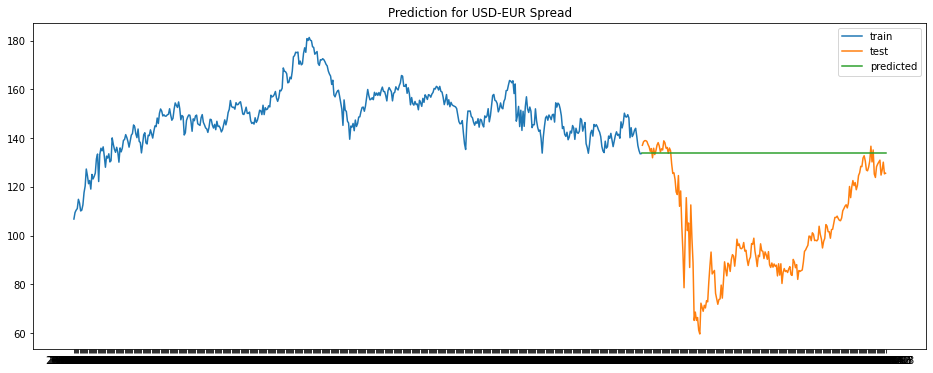

RMSE: 36.91


In [115]:
# Out-of-sample multi-step-forecast based on auto_arima results
predicted = results.predict(n_periods=len(test))
predicted = pd.DataFrame(predicted, index=test.index, columns=['predicted'])

plot_train_test(train, test, predicted)

In [24]:
# ARIMA multi-step-forecast is pretty bad, so let's compare it with one-step-forecast
def one_step_forecast():
    predicted, conf_int = results.predict(n_periods=1, return_conf_int=True)
    return (
        predicted.tolist()[0],
        np.asarray(conf_int).tolist()[0])

predictions = []
confidence_intervals = []

for x in test:
    predicted, conf = one_step_forecast()
    predictions.append(predicted)
    confidence_intervals.append(conf)

    # Updates the existing model
    results.update(x)

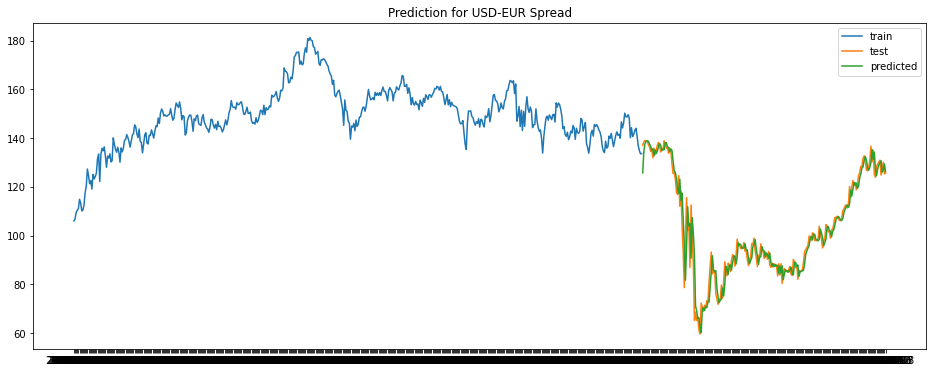

RMSE: 5.17


In [25]:
# Out-of-sample one-step-forecast based on auto_arima results
predicted = pd.DataFrame(predictions, index=test.index, columns=['predicted'])

# Plot real price vs one-step-forecast
plot_train_test(train, test, predicted)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
#print(f'RMSE: {rmse:.2f}')

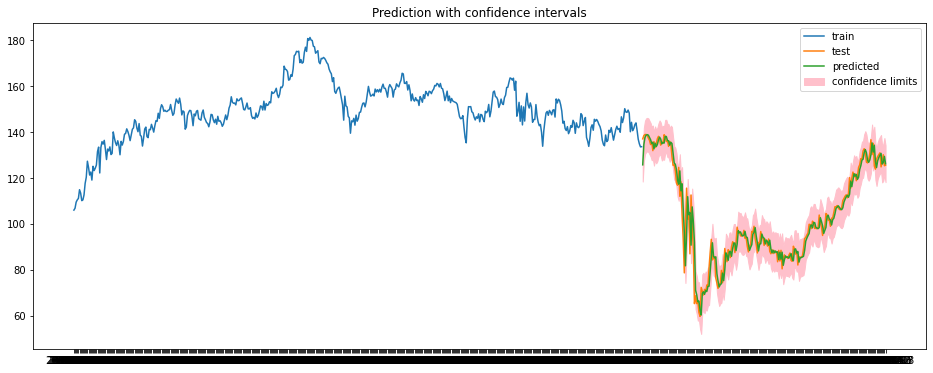

In [27]:
# Forecast with confidence intervals
lower_limits = [row[0] for row in confidence_intervals]
upper_limits = [row[1] for row in confidence_intervals]
# Plot predictions with conf_int
plt.figure(figsize=(16,6))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(predicted, label='predicted')
plt.fill_between(test.index, lower_limits, upper_limits, color='pink', label='confidence limits')
plt.title('Prediction with confidence intervals')
plt.legend()
plt.show()

In [28]:
# Let's make predictions other way
# SARIMAX 
# one-step-ahead in-sample predictions with uncertainty
def sarimax_model(df, trend='ct', steps=100, dynamic=False):
    model = SARIMAX(df, order=(7,1,7), trend=trend)
    results = model.fit()
    one_step_forecast = results.get_prediction(start=-steps, dynamic=dynamic)
    # Get in-sample predicted mean values
    predictions = one_step_forecast.predicted_mean
    # Get confidence intervals of in-sample forecasts
    confidence_intervals = one_step_forecast.conf_int()
    lower_limits = confidence_intervals['lower Spread']
    upper_limits = confidence_intervals['upper Spread']
    return predictions, lower_limits, upper_limits

In [29]:
# Plot real data
def plot_sarimax_pred(df, steps=100):
    plt.figure(figsize=(16,6))
    plt.plot(df.index[-steps:], df[-steps:], 
            color='b', label='real data')
    # Plot predictions 
    plt.plot(predictions.index, predictions, 
            color='g', label='predicted')
    # Plot confidence limits
    plt.fill_between(lower_limits.index, lower_limits,
            upper_limits, color='pink', label='confidence limits')
    plt.title('EUR-USD Spread Prediction for last 50 days')
    plt.legend()
    plt.show()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


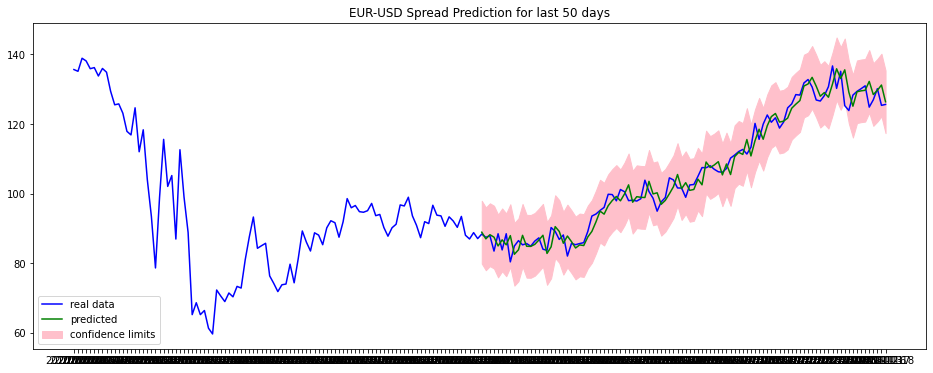

In [30]:
# Run model
predictions, lower_limits, upper_limits =sarimax_model(df=test, trend='ct', steps=100, dynamic=False)
plot_sarimax_pred(df=test, steps=200)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


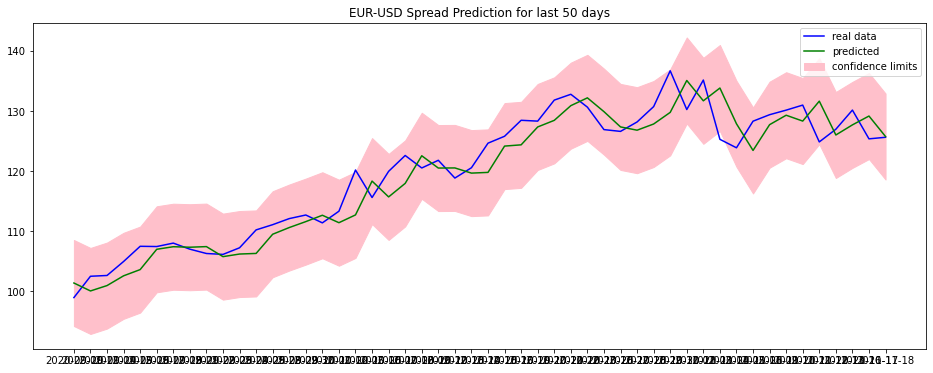

In [31]:
# One-step-forecast for next 50 days
# Run model
predictions, lower_limits, upper_limits = sarimax_model(df=df['Spread'], trend='ct', steps=50, dynamic=False)
# Plot one-step-forecast for comparison with multi-step-forecast
plot_sarimax_pred(df=df['Spread'], steps=50)   

In [32]:
# Compare predictions with real data
forecast_vs_real = pd.concat([round(df['Spread'][-50:],2), round(predictions,2)], axis=1)
forecast_vs_real.columns = ['Real Price', 'Forecast']
forecast_vs_real['Error_%'] = round(abs(forecast_vs_real['Forecast'] - forecast_vs_real['Real Price'])/\
                        forecast_vs_real['Real Price'] * 100, 1)
print(forecast_vs_real)
print()
print(f"Mean error: {round(forecast_vs_real['Error_%'].mean(),1)} %")

            Real Price  Forecast  Error_%
Date                                     
2020-09-10       98.93    101.36      2.5
2020-09-11      102.48    100.03      2.4
2020-09-14      102.61    100.93      1.6
2020-09-15      104.94    102.56      2.3
2020-09-16      107.47    103.59      3.6
2020-09-17      107.43    106.97      0.4
2020-09-18      108.00    107.40      0.6
2020-09-21      106.99    107.31      0.3
2020-09-22      106.27    107.42      1.1
2020-09-23      106.12    105.75      0.3
2020-09-24      107.22    106.18      1.0
2020-09-25      110.20    106.28      3.6
2020-09-28      111.07    109.48      1.4
2020-09-29      112.08    110.59      1.3
2020-09-30      112.68    111.58      1.0
2020-10-01      111.37    112.64      1.1
2020-10-02      113.31    111.40      1.7
2020-10-05      120.17    112.69      6.2
2020-10-06      115.59    118.33      2.4
2020-10-07      119.95    115.69      3.6
2020-10-08      122.59    117.94      3.8
2020-10-09      120.51    122.54  

In [100]:
# Calculate volatility
volatility = df['Returns'].std()

# Print volatility
print(f'''Daily volatility: {volatility:.2f}% 
Monthly volatility: {np.sqrt(21)*volatility:.2f}% 
Annual volatility: {np.sqrt(252)*volatility:.2f}% ''')

Daily volatility: 3.81% 
Monthly volatility: 17.46% 
Annual volatility: 60.48% 


In [224]:
# Specify GARCH model function
def garch_model(df, p=1, o=0, q=1, mean='constant', vol = 'GARCH', 
                dist='normal'):
    model = arch_model(
        df, 
        p = p, o=o, q = q, 
        mean = mean,
        vol = vol,
        dist = dist
    )
    return model

In [225]:
# Implement a basic GARCH model
basic_gm = garch_model(df['Returns']) 
# Fit the model
gm_result = basic_gm.fit(disp='off', show_warning=False)

# Display model fitting summary
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -1853.99
Distribution:                  Normal   AIC:                           3715.98
Method:            Maximum Likelihood   BIC:                           3734.31
                                        No. Observations:                  722
Date:                Sat, Dec 05 2020   Df Residuals:                      718
Time:                        17:38:54   Df Model:                            4
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1141      0.103      1.106      0.269 [-8.80

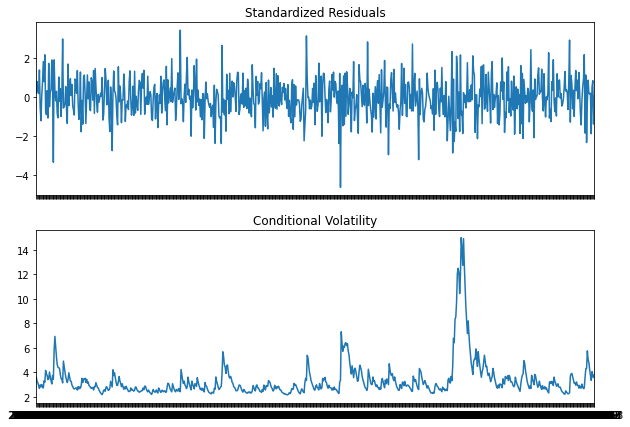

In [226]:
# Plot fitted results
plt.rc("figure", figsize=(10, 7))
gm_result.plot()
plt.show()

In [227]:
# Obtain model estimated residuals and volatility
# Residual = predicted price - real price
gm_resid = gm_result.resid
# Predicted price volatility (std)
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid / gm_std

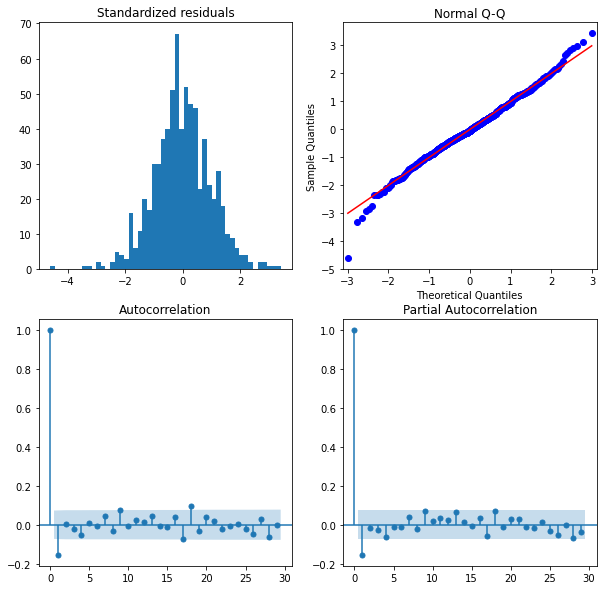

In [228]:
# Diagnose plot of residuals
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.hist(gm_std_resid, bins = 50)
ax1.set_title('Standardized residuals')
qqplot(gm_std_resid, line='s', ax=ax2)
ax2.set_title('Normal Q-Q')
plot_acf(gm_std_resid, ax=ax3)
plot_pacf(gm_std_resid, ax=ax4)
plt.show()

In [229]:
# Specify GJR-GARCH model assumptions
gjr_gm = garch_model(df['Returns'], o=1, dist = 'skewt') 

# Fit the model
gjr_result = gjr_gm.fit(disp='off', show_warning=False)

# Get model estimated volatility
gjr_vol = gjr_result.conditional_volatility

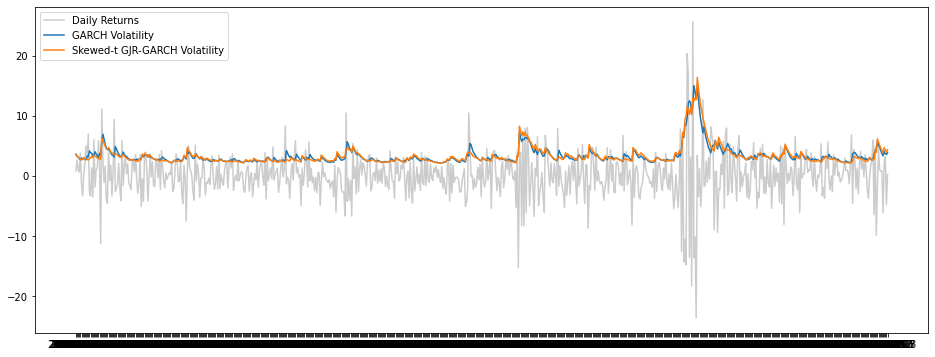

Correlation coef between GARCH & skewed-t GJR=GARCH: 0.96


In [230]:
# Plot model fitting results
plt.rc("figure", figsize=(16, 6))
gm_vol = gm_result.conditional_volatility
plt.plot(df['Returns'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.plot(gm_vol, label = 'GARCH Volatility')
plt.plot(gjr_vol, label = 'Skewed-t GJR-GARCH Volatility')
plt.legend(loc = 'upper left')
plt.show()
print(f'Correlation coef between GARCH & skewed-t GJR=GARCH: {round(np.corrcoef(gm_vol, gjr_vol)[0,1],2)}')

In [241]:
# In-sample rolling window one-step-forecast
index = df.index
end_loc = len(df)-50
forecasts = {}
for i in range(50):
    # Specify fixed rolling window size for model fitting
    gm_result = basic_gm.fit(last_obs = i + end_loc,
                             disp='off', show_warning=False)
    # Conduct 1-period variance forecast and save the result
    temp_result = gm_result.forecast(horizon = 1).variance
    #print(temp_result)
    #print(temp_result.iloc[i + end_loc])
    fcast = temp_result.iloc[i + end_loc]
    forecasts[fcast.name] = fcast
    
# Save all forecast to a dataframe    
forecast_var = pd.DataFrame(forecasts).T
forecast_var.columns = ['Forecast']

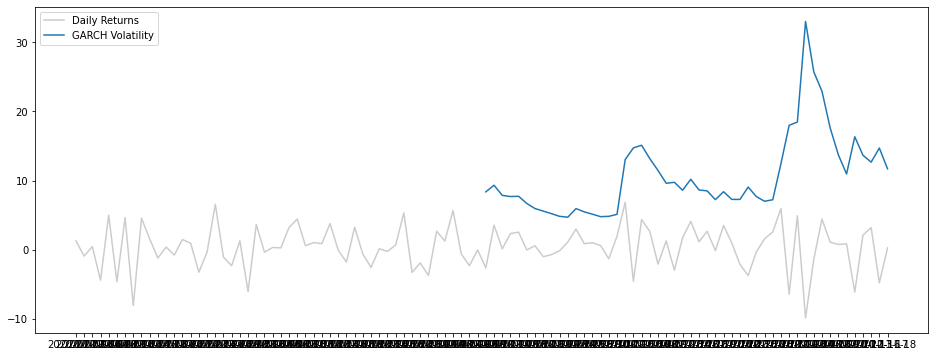

In [242]:
# Plot in-sample forecast and real volatility
plt.plot(df.Returns[-100:], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.plot(forecast_var.Forecast, label = 'GARCH Volatility')
plt.legend(loc = 'upper left')
plt.show()

Train: 505, Test: 217


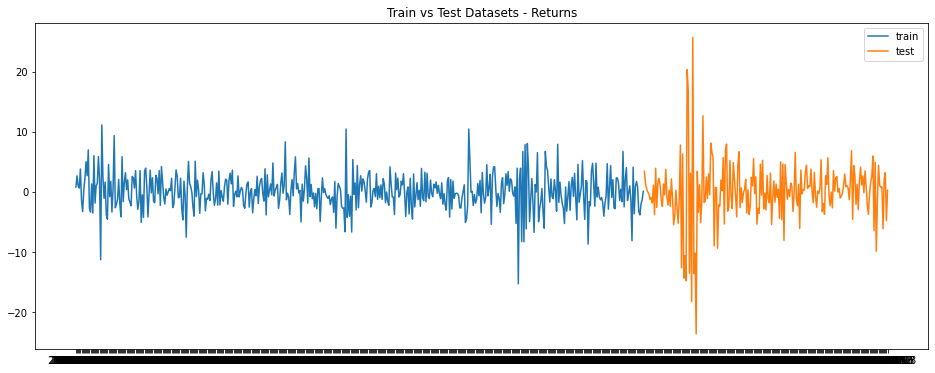

In [285]:
# Now let's try forecast on test date
train, test = train_test_split(X=df[['Spread','Returns']], size=0.7)
print(f'Train: {len(train)}, Test: {len(test)}')

# Plot train & test returns
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(train['Returns'],label='train')
ax.plot(test['Returns'],label='test')

ax.legend()
plt.title("Train vs Test Datasets - Returns")
plt.show()

In [373]:
# Out-of-sample rolling window one-step-forecast
rolling_predictions = []
train_update = train['Returns']
for i in range(test.shape[0]):
    model = garch_model(train_update, p=1, o=1, q=1)
    model_fit = model.fit(update_freq=1, disp='off',show_warning=False)
    pred = model_fit.forecast(horizon=1)
    train_update = pd.concat([train['Returns'], test['Returns'].iloc[0:i+1]])
    #print(np.sqrt(pred.variance.values[-1,:][0]))
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

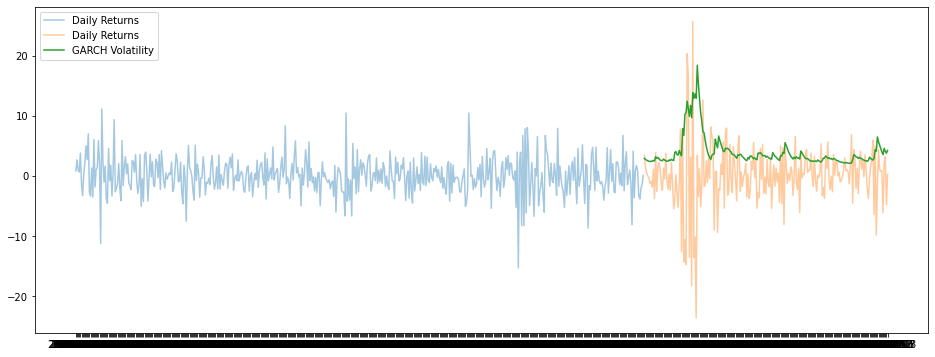

In [374]:
# Plot out-of-sample forecast and real volatility
rolling_predictions = pd.DataFrame(rolling_predictions, index=test.index)
plt.plot(train['Returns'], 
         label = 'Daily Returns', alpha = 0.4)
plt.plot(test['Returns'], 
         label = 'Daily Returns', alpha = 0.4)
plt.plot(rolling_predictions, 
         label = 'GARCH Volatility')
plt.legend(loc = 'upper left')
plt.show()

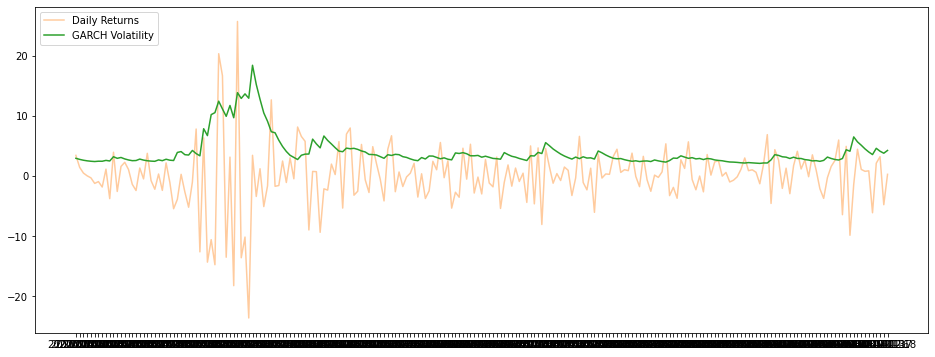

In [375]:
# Plot only test data with forecasted returns
plt.plot(test['Returns'], color = 'C1', 
         label = 'Daily Returns', alpha = 0.4)
plt.plot(rolling_predictions, color = 'C2',
         label = 'GARCH Volatility')
plt.legend(loc = 'upper left')
plt.show()

In [376]:
rolling_predictions.columns = ['predicted_returns']
rolling_predictions['last_spread'] = 0

In [377]:
for i in range(1,len(rolling_predictions)):
    rolling_predictions['last_spread'][i] = test['Spread'][i-1]
    #print(rolling_predictions['predicted_returns'][i+1]+test['Spread'][i])

rolling_predictions = rolling_predictions.drop(rolling_predictions.index[0])

rolling_predictions['predicted_spread'] = rolling_predictions['last_spread']+rolling_predictions['predicted_returns']

<ipython-input-377-f4a84ea8dcdb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rolling_predictions['last_spread'][i] = test['Spread'][i-1]


In [378]:
print(rolling_predictions)

            predicted_returns  last_spread  predicted_spread
Date                                                        
2020-01-17           2.742505          137        139.742505
2020-01-20           2.602673          138        140.602673
2020-01-21           2.502317          138        140.502317
2020-01-22           2.431859          138        140.431859
2020-01-23           2.386198          138        140.386198
...                       ...          ...               ...
2020-11-12           3.542178          130        133.542178
2020-11-13           4.582280          124        128.582280
2020-11-16           4.100619          126        130.100619
2020-11-17           3.769215          130        133.769215
2020-11-18           4.229330          125        129.229330

[216 rows x 3 columns]


In [379]:
# Compare predictions with real data
forecast_vs_real = pd.concat([test['Spread'], rolling_predictions['predicted_spread']], axis=1)
forecast_vs_real.columns = ['Real Price', 'Forecast']
forecast_vs_real['Error_%'] = round(abs(forecast_vs_real['Forecast'] - forecast_vs_real['Real Price'])/\
                        forecast_vs_real['Real Price'] * 100, 1)
print(forecast_vs_real)
print()
print(f"Mean error: {round(forecast_vs_real['Error_%'].mean(),1)} %")

            Real Price    Forecast  Error_%
2020-01-16      137.08         NaN      NaN
2020-01-17      138.50  139.742505      0.9
2020-01-20      138.97  140.602673      1.2
2020-01-21      138.98  140.502317      1.1
2020-01-22      138.65  140.431859      1.3
...                ...         ...      ...
2020-11-12      124.85  133.542178      7.0
2020-11-13      126.96  128.582280      1.3
2020-11-16      130.15  130.100619      0.0
2020-11-17      125.36  133.769215      6.7
2020-11-18      125.62  129.229330      2.9

[217 rows x 3 columns]

Mean error: 5.0 %
